In [75]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import plot_model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [46]:
train_dir = './archive2/fingers/train'
test_dir = './archive2/fingers/test'
img_height, img_width = 128, 128 
batch_size = 32

In [47]:
def extract_label(filename):
    return filename.split('_')[1][0]

In [48]:
def create_dataframe(directory):
    data = {'filename': [], 'label': []}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                label = extract_label(file)
                data['filename'].append(filepath)
                data['label'].append(label)
    return pd.DataFrame(data)

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

Found 14400 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


In [50]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.summary()

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 128)      

In [51]:
epochs = 25

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/25


2024-05-26 02:39:13.019813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - ETA: 0s - loss: 1.7893 - accuracy: 0.2303

2024-05-26 02:39:35.792718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - 25s 54ms/step - loss: 1.7893 - accuracy: 0.2303 - val_loss: 1.7833 - val_accuracy: 0.2006
Epoch 2/25
450/450 [==============================] - 23s 51ms/step - loss: 1.7799 - accuracy: 0.2299 - val_loss: 1.7737 - val_accuracy: 0.2073
Epoch 3/25
450/450 [==============================] - 23s 52ms/step - loss: 1.7689 - accuracy: 0.2322 - val_loss: 1.7618 - val_accuracy: 0.2132
Epoch 4/25
450/450 [==============================] - 23s 52ms/step - loss: 1.7565 - accuracy: 0.2416 - val_loss: 1.7461 - val_accuracy: 0.2176
Epoch 5/25
450/450 [==============================] - 24s 52ms/step - loss: 1.7375 - accuracy: 0.2578 - val_loss: 1.7228 - val_accuracy: 0.2606
Epoch 6/25
450/450 [==============================] - 24s 53ms/step - loss: 1.7090 - accuracy: 0.2990 - val_loss: 1.6858 - val_accuracy: 0.3457
Epoch 7/25
450/450 [==============================] - 24s 52ms/step - loss: 1.6618 - accuracy: 0.4326 - val_loss: 1.6236 - val_accuracy: 0.5254
Epo

In [ ]:
model.save('finger_count_model.h5')

In [52]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Точность на тестовых данных:', test_acc)

112/112 [==============================] - 2s 15ms/step - loss: 0.0740 - accuracy: 0.9738
Точность на тестовых данных: 0.9737723469734192


1/1 [==============================] - 0s 21ms/step


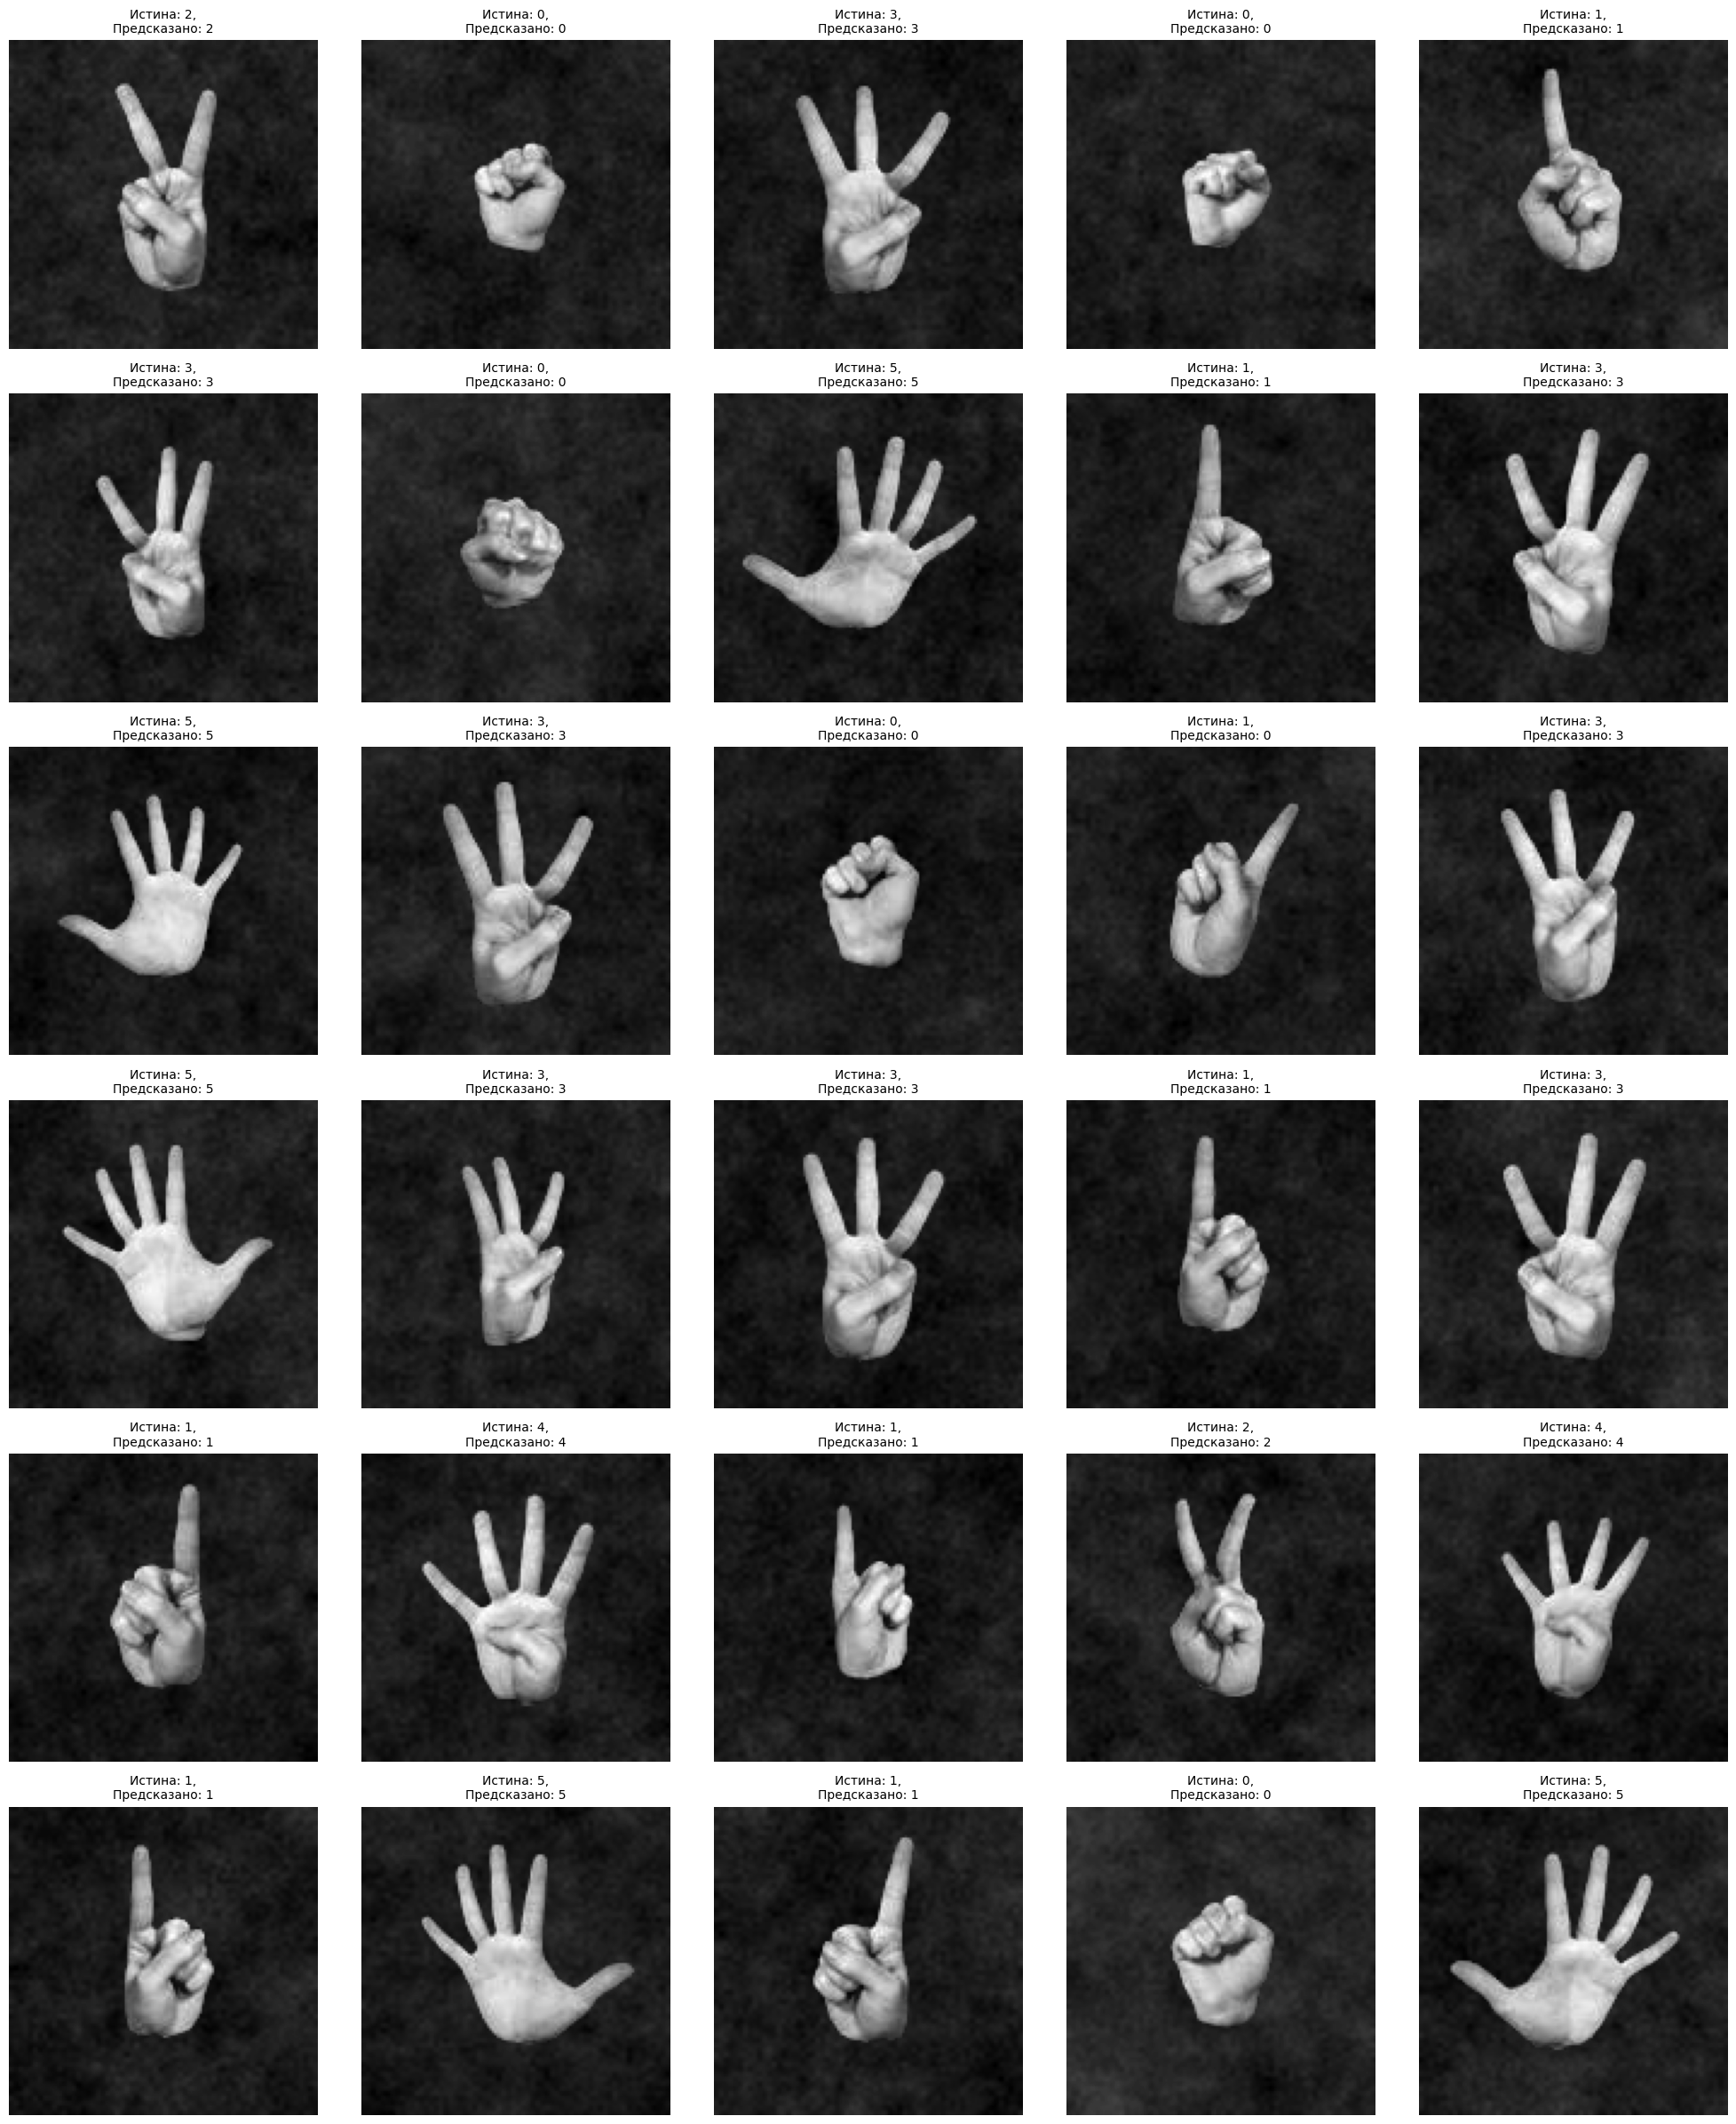

In [74]:
def plot_images_with_predictions(generator, model, num_images):
    images, labels = next(generator)
    predictions = model.predict(images)
    rows = (num_images // 5) + 1
    cols = 5
    
    plt.figure(figsize=(20, 4 * rows))
    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        real_class = np.argmax(labels[i])
        predicted_class = np.argmax(predictions[i])
        plt.title(f'Истина: {real_class},\nПредсказано: {predicted_class}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_images_with_predictions(test_generator, model, 30)

1/1 [==============================] - 0s 15ms/step


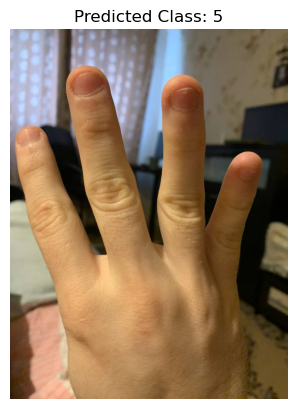

In [77]:
def load_and_preprocess_image(img_path, img_height, img_width):
    # Загружаем цветное изображение
    img = cv2.imread(img_path)
    # Преобразуем его в черно-белое
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Изменяем размер изображения
    img_resized = cv2.resize(img_gray, (img_height, img_width))
    # Преобразуем изображение в массив
    img_array = np.array(img_resized, dtype='float32')
    # Нормализуем изображение
    img_array = img_array / 255.0
    # Добавляем размерность для batch
    img_array = np.expand_dims(img_array, axis=-1)  # добавляем канал
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Функция для выполнения предсказания и отображения изображения с предсказанным классом
def predict_and_plot(img_path, model, img_height, img_width):
    # Загружаем и предобрабатываем изображение
    img_array = load_and_preprocess_image(img_path, img_height, img_width)
    
    # Выполняем предсказание
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    
    # Загружаем и отображаем исходное изображение
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Путь к вашему изображению
img_path = 'test.jpg'  # Укажите путь к вашему изображению


# Выполняем предсказание и отображаем результат
predict_and_plot(img_path, model, img_height, img_width)